In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup,AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
df = pd.read_csv("sample.csv")

In [3]:
df

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
82509,Education is an essential tool for an individu...,1
82510,\nThe subject of students committing to a care...,1
82511,"Dear Senator,\n\nI am writing to express my vi...",1
82512,"Dear Senator,\n\nI am writing to you today to ...",1


In [4]:


def split_dataset_by_label_count(data, label_column, num_splits):
    """
    Split a dataset into a specified number of parts with an equal number of each label in each part.

    Parameters:
        data (DataFrame): The dataset to be split.
        label_column (str): The name of the column containing the labels.
        num_splits (int): The number of splits to create.

    Returns:
        list: A list containing the split parts of the dataset.
    """
    # Shuffle the dataset
    shuffled_data = data.sample(frac=1)

    # Group data by labels
    grouped = shuffled_data.groupby(label_column)

    # Initialize empty lists to store split parts
    split_parts = [[] for _ in range(num_splits)]

    # Iterate over groups and distribute them evenly across the split parts
    for label, group in grouped:
        # Calculate the number of samples for each split part
        samples_per_split = len(group) // num_splits

        # Distribute samples evenly across split parts
        for i in range(num_splits):
            start_idx = i * samples_per_split
            end_idx = start_idx + samples_per_split
            split_parts[i].append(group.iloc[start_idx:end_idx])

    # Concatenate split parts and return as DataFrames
    return [pd.concat(split_part) for split_part in split_parts]


In [5]:


# Split the dataset into four parts with an equal number of each label in each part
num_splits = 16
split_parts = split_dataset_by_label_count(df, 'generated', num_splits)

# Create separate DataFrames for each split
t1, t2, t3, t4, t5, t6 ,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16 = split_parts


In [67]:
t4

,text,generated
21345,"Summer projects, some schools have these proje...",0
18800,Aliens! Ha not true. In the article Unmasking...,0
30644,Many today are so concerned with driving safel...,0
39265,This story explains how fascinating Venus is. ...,0
12707,"When you give someone advice, you have to give...",0
...,...,...
44619,"Code]\n\nDear [Senator's Name],\n\nI am writin...",1
44681,Drivers Should Not Use Cell Phones While Opera...,1
67652,Arts educations is like super important and st...,1
44982,Drivers Should Not Use Cell Phones in Any Capa...,1


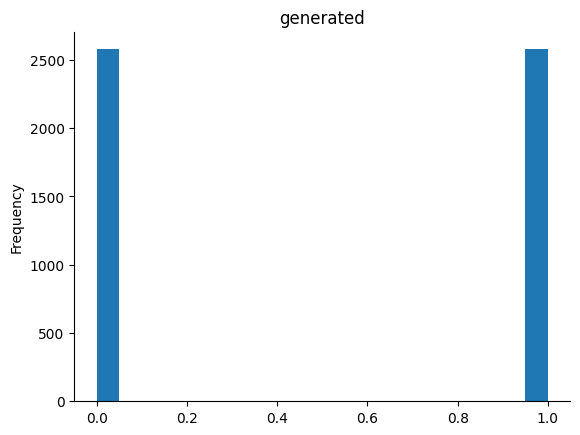

In [68]:
from matplotlib import pyplot as plt
t2['generated'].plot(kind='hist', bins=20, title='generated')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [69]:
# Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(t1.iloc[:, 0], t1.iloc[:, 1], test_size=0.2, random_state=42)



In [70]:
train_texts.shape

(4124,)

In [53]:
train_labels


724      0
47859    1
17540    0
12965    0
37796    0
        ..
76608    1
10045    0
50787    1
60421    1
14262    0
Name: generated, Length: 4124, dtype: int64

In [54]:
test_texts.shape

(1032,)

In [55]:
# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [56]:
# Tokenize the text data
max_len = 128
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding='max_length', max_length=max_len)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding='max_length', max_length=max_len)

In [57]:
test_encodings

{'input_ids': [[101, 4931, 2045, 999, 1045, 1005, 1049, 1037, 3694, 1022, 3076, 1998, 1045, 1005, 1049, 2182, 2000, 3745, 2026, 4301, 2006, 1996, 6263, 11897, 5981, 1012, 2061, 1010, 2323, 2057, 5333, 1996, 6263, 11897, 1999, 2256, 2406, 2030, 2025, 1029, 2092, 1010, 2292, 1005, 1055, 11529, 2046, 1996, 4013, 2015, 1998, 9530, 2015, 1012, 2034, 2125, 1010, 6274, 1996, 6263, 11897, 2064, 2393, 12455, 7796, 1037, 2542, 11897, 1012, 2017, 2156, 1010, 1037, 2542, 11897, 2003, 1996, 3815, 1997, 2769, 1037, 2711, 3791, 2000, 2191, 2000, 3104, 3937, 11727, 2066, 2833, 1010, 3847, 1010, 1998, 9871, 1012, 1998, 2292, 1005, 1055, 2022, 2613, 1010, 2009, 1005, 1055, 7823, 2000, 2191, 4515, 3113, 2043, 2017, 1005, 2128, 2551, 2005, 27613, 1012, 2011, 6274, 1996, 6263, 11897, 1010, 2057, 102], [101, 2467, 2725, 2242, 2009, 1005, 1055, 2488, 2084, 2725, 2498, 1012, 6595, 1999, 1996, 2168, 2173, 2073, 2017, 2732, 2003, 2488, 1025, 2174, 1010, 2725, 2242, 2003, 2467, 2488, 1012, 2009, 2003, 2488, 2000

In [58]:
# Convert the labels to tensor
train_labels = torch.tensor(train_labels.tolist())
test_labels = torch.tensor(test_labels.tolist())

In [59]:
test_labels

tensor([1, 0, 1,  ..., 1, 1, 1])

In [60]:
# Create PyTorch datasets
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              train_labels)
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             test_labels)

In [61]:
test_dataset 

In [62]:
# Define batch size
batch_size = 16

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [63]:
test_loader

In [23]:
# Load pre-trained BERT model for sequence classification
model =AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
# Load the saved state dictionary into the model
model.load_state_dict(torch.load('bert_model.pth'))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [24]:
# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 5)

C:\Users\91884\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
# Function to calculate accuracy
def compute_accuracy(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

In [64]:
# Assuming you have verified GPU availability

# Training loop
epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

for epoch in range(epochs):
  model.train()
  total_loss = 0

  for batch in train_loader:
    input_ids, attention_mask, labels = batch

    # Move data to GPU
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    total_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

  avg_train_loss = total_loss / len(train_loader)

  model.eval()
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in test_loader:
    input_ids, attention_mask, labels = batch

    # Move data to GPU
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
      logits = outputs.logits
      logits = logits.detach().cpu().numpy()
      label_ids = labels.to('cpu').numpy()
      tmp_eval_accuracy = compute_accuracy(logits, label_ids)
      eval_accuracy += tmp_eval_accuracy
      nb_eval_steps += 1

  print(f"Epoch {epoch+1}/{epochs}")
  print(f"Training Loss: {avg_train_loss}")
  print(f"Validation Accuracy: {eval_accuracy/nb_eval_steps}")


Epoch 1/3
Training Loss: 0.0037580542787812496
Validation Accuracy: 0.9586538461538462
Epoch 2/3
Training Loss: 0.001488277150723337
Validation Accuracy: 0.9576923076923077
Epoch 3/3
Training Loss: 0.00013733982667654064
Validation Accuracy: 0.9576923076923077


In [66]:
# Evaluation
model.eval()
predictions, true_labels = [], []

for batch in test_loader:
    input_ids, attention_mask, labels = batch
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()
    predictions.extend(logits)
    true_labels.extend(label_ids)

print(classification_report(np.argmax(predictions, axis=1), true_labels))


              precision    recall  f1-score   support

           0       0.92      0.99      0.96       471
           1       0.99      0.93      0.96       561

    accuracy                           0.96      1032
   macro avg       0.96      0.96      0.96      1032
weighted avg       0.96      0.96      0.96      1032



In [74]:
texth="""No Phones Behind The Wheel

Cell phones are devices that connects people all around the world and also is a main way of communication. Through the use of social media such as twitter, snapchat, and instagram many can interact with each other electronically rather than in person. Not only did these devices create a new platform of communication, but also expanded the idea of social interaction. However, cell phones are known to become very addictive and can be considered a hazardous device when used under the wrong circumstances. It can become a major distraction and even put many lives in danger, including the driver. Drivers should not be able to use cell phones while operating a vehicle as it can cause life threatening accidents, inattentional blindness, and goes against the law in many states.

As millions of people use cars as a mode of transportation, cellular devices can easily be accessed on a regular basis and put drivers at risk of a serious accident. Not only could this affect one person, but also others in the roadway that are also in risk due terrible decision making by one person. As these devices become more of an occurrence, studies have shown,""

....annual injury and fatal reports found that the use of cellphones causes 26% of the nation's car accidents, a modest increase from the previous year"" (USA Today). This comes to show that about one fourth of car accidents are caused by cell phones, very dangerous and deadly device that can change an outcome on the roadway in a heartbeat. All in all, as people become more dependent on phones, the percentage of car accidents will only increase throughout the years.

Inattentional blindness is a resulting factor from cellular devices as it draws attention away from the road and results in not fully noticing visible objects in plain sight. A main example of this is driving while texting; as the brain is focused on sending out a text, an individual can fail to perceive an object from the corner of their eye. Even though the humans brain is advanced in so many ways, it still has its difficulties,"" When we are driving, the is a huge amount of sensory information that our brain must deal with"" (Pammer). As a result, drivers can not one hundred percent focus on driving and sending out a text at the same time due limited usage of how the brain works. Thus, by having temporary inattentional blindness drivers can put their lives and other lives at risk as well simply because their lack of attention on the highway.

In addition, not only can driving while using a cellular device lead to a fatal or very serious accident, but it also be illegal depending on the state. By texting and driving in states like Georgia, a driver can face fines when caught by the police. This law which is banning people by physically using their cell phones while driving only adds more safety precaution,"" Those caught breaking the rules- even tapping ""play"" on a spotify playlist while not parked- face a 50$ fine which doubles upon their second offense"" (USA Today). Due to more and more people being prone to car accidents as a result of cell phone usage, more laws are being made to punish these users so fatalities or injuries can be prevented. To sum up, as drivers become more attached to their phones and abuse their right to drive legally, punishments are being made to keep the road safe and protected from reckless driving.

In conclusion, cell phones also has many positives as it increases the way many people interact with one another. Google maps and different other apps can be very beneficial when it comes to finding specific locations. However, with many perks comes many flaws as these devices can cause a life changing accident in a matter of seconds. It can also be a sneaky distractor in which it can take a drivers full attention off the road and minimize their vision on it. Heavy fines and serious consequences may be taken place when a cellular device is used in a state where it is illegal. In summary, as this very popular innovation develops, drastic measures have to be taken into place to prevent harmful disasters on the roads."""

text = """NASA's most recent Mars rover expedition stands as a testament to humanity's unyielding quest for knowledge and exploration. The mission, dubbed "Red Horizon," marks a milestone in space exploration, showcasing cutting-edge technology and scientific ingenuity.

At the heart of this expedition lies the Perseverance rover, a marvel of engineering designed to unravel the mysteries of the Martian surface. Equipped with an array of state-of-the-art instruments, Perseverance aims to characterize the geology of Mars, search for signs of past microbial life, and pave the way for future human exploration.

One of the key objectives of the mission is to collect samples of Martian rocks and soil for eventual return to Earth. This ambitious endeavor involves sophisticated sample caching mechanisms and collaboration with future missions to retrieve these precious specimens, offering scientists unprecedented insights into the Red Planet's history and evolution.

Furthermore, Perseverance carries onboard the Ingenuity helicopter, a technological marvel that promises to revolutionize planetary exploration. Ingenuity's successful flight tests demonstrate the viability of aerial reconnaissance on Mars, opening up new avenues for scouting potential landing sites and conducting detailed surveys of the Martian terrain.

In addition to its scientific goals, the Red Horizon mission exemplifies international cooperation, with contributions from various space agencies and research institutions around the globe. This collaborative spirit underscores humanity's collective endeavor to unravel the mysteries of the cosmos and expand the boundaries of human knowledge.

As the Perseverance rover continues its journey across the Martian landscape, each new discovery serves as a reminder of the boundless potential of human exploration. From its innovative technology to its groundbreaking scientific discoveries, NASA's latest Mars rover expedition reaffirms our commitment to pushing the boundaries of what is possible and inspires generations to come to reach for the stars."""


In [75]:
# Custom text input
custom_text = texth

# Preprocess the text
encoded_input = tokenizer(custom_text, padding=True, truncation=True, return_tensors="pt")

# Perform inference
with torch.no_grad():
    model.eval()
    outputs = model(**encoded_input)

# Get predicted class probabilities
predicted_probabilities = torch.softmax(outputs.logits, dim=1).tolist()[0]

# Get predicted class (class with highest probability)
predicted_class = torch.argmax(outputs.logits, dim=1).item()

# Print results
print("Custom Text:", custom_text)
print("Predicted Class:", predicted_class)
print("Predicted Class Probabilities:", predicted_probabilities)

Custom Text: No Phones Behind The Wheel

Cell phones are devices that connects people all around the world and also is a main way of communication. Through the use of social media such as twitter, snapchat, and instagram many can interact with each other electronically rather than in person. Not only did these devices create a new platform of communication, but also expanded the idea of social interaction. However, cell phones are known to become very addictive and can be considered a hazardous device when used under the wrong circumstances. It can become a major distraction and even put many lives in danger, including the driver. Drivers should not be able to use cell phones while operating a vehicle as it can cause life threatening accidents, inattentional blindness, and goes against the law in many states.

As millions of people use cars as a mode of transportation, cellular devices can easily be accessed on a regular basis and put drivers at risk of a serious accident. Not only cou

In [48]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), 'bert_model.pth')
